In [1]:
from netCDF4 import Dataset

import numpy as np
import matplotlib.pyplot as plt
import os
from utils.upscale import Upscale
import torch

In [2]:
with Dataset(os.path.join('data', 'wind_psl', 'pr.std.nc4'), "r", format="NETCDF4") as file:
    std = file['pr'][0].item()

In [3]:
with Dataset(os.path.join('data', 'wind_psl', 'orog.std.nc4'), "r", format="NETCDF4") as file:
    std_orog = file['orog'][0].item()

 Commonly used threshold to define dry_days is 0.1 mm/day


In [4]:
threshold = 0.1

## Functions

### Units:
The output of edvae is precipitation_flux $\left[\frac{\text{kg}}{\text{m}^2 \text{s}}\right]$ divided by its standard deviation over all years and grid points.

In [5]:
def normalized_flux_to_mm_per_d(pr_norm_flux, std):
    return pr_norm_flux * std * 60 * 60 * 24
def mm_per_d_to_normalized_flux(mm_per_day, std):
    return mm_per_day / std / 60 / 60 / 24

In [6]:
def wet_days_percentile(pr, percentile):
    w_days = np.zeros(pr.shape[1:])
    for i in range(pr.shape[1]):
        for j in range(pr.shape[2]):
            if len(pr[:,i,j][pr[:,i,j] > threshold]) == 0:
                w_days[i,j]
            else:
                w_days[i,j] = np.percentile(pr[:,i,j][pr[:,i,j] > threshold], percentile)
    return w_days 

In [7]:
def read_data(path, test_times=False, mean_downscaled=False, orog=False):
    with Dataset(path, "r", format="NETCDF4") as file:
        if test_times:
            pr = file['pr'][:]
            pr_recon = file['downscaled_pr_0'][:]
            pr_interpol = file['bilinear_downscaled_pr'][:]
        else:
            pr = file['pr'][:,4:-4,4:-4]
            pr_recon = file['downscaled_pr_0'][:,4:-4,4:-4]
            pr_interpol = file['bilinear_downscaled_pr'][:,4:-4,4:-4]
        t = len(file['time'])
        # convert to mm/d
        pr = normalized_flux_to_mm_per_d(pr, std)
        pr_recon = normalized_flux_to_mm_per_d(pr_recon, std)
        pr_interpol = normalized_flux_to_mm_per_d(pr_interpol, std)
        
        if mean_downscaled:
            if test_times:
                pr_recon = file['mean_downscaled_pr_0'][:]
            else:
                pr_recon = file['mean_downscaled_pr_0'][:,4:-4,4:-4]
            pr_recon = normalized_flux_to_mm_per_d(pr_recon, std)
        if orog:
            orog = file['orog'][4:-4,4:-4]
            return pr, pr_recon, pr_interpol, t, orog         
    return pr, pr_recon, pr_interpol, t

In [8]:
def plot_percentiles(paths, area, percentiles, test_times=False, mean_downscaled=False, vlims=None):
    fontsize = 10
    fig, axes = plt.subplots(len(percentiles)+1, len(paths)+2, sharex=True, sharey=True, figsize = (14, 6))
    for ax, col in zip(axes[0], ['Observed', 'Bilinear Interpolated']+paths):
        if len(col.split('/')) > 1: # Only plot relevant part of path
            ax.set_title(col.split('/')[1], fontsize=fontsize)
        else:
            ax.set_title(col, fontsize=fontsize) # observed and bilinear interpolation
    for ax, percentile in zip(axes[:,0], ['RDDF']+percentiles):
        if percentile == 'RDDF':
            ax.set_ylabel('RDDF'.format(percentile), rotation=90, fontsize=fontsize)
        else:
            ax.set_ylabel('{}th Percentile'.format(percentile), rotation=90, fontsize=fontsize)
    
    pr, _, pr_interpol, t, orog = read_data(path=os.path.join(paths[0], area), test_times=test_times,
                                      mean_downscaled=mean_downscaled,orog=True)
    # plot rddf
    rddf_pr = np.sum(pr <= 0.1,axis=0)/t
    rddf_interpol = np.sum(pr_interpol <= 0.1, axis=0)/t
    axes[0,0].imshow(rddf_pr, cmap=plt.get_cmap('jet'), vmin=0, vmax=1)
    axes[0,0].contour(orog*std_orog, cmap=plt.get_cmap('Greys'), levels=[250,1000,1750,2500], linewidths=1)
    axes[0,1].imshow(rddf_interpol, cmap=plt.get_cmap('jet'), vmin=0, vmax=1)
    axes[0,1].contour(orog*std_orog, cmap=plt.get_cmap('Greys'), levels=[250,1000,1750,2500], linewidths=1)
    # plot pr and interpol_pr, set v_min, v_max to the pr max and min value
    if vlims is None:
        vlims = []
    for i in range(len(percentiles)):
        pr_percentile = wet_days_percentile(pr, percentiles[i])
        if len(vlims) < len(percentiles):
            vmin = pr_percentile.min()
            vmax = pr_percentile.max()
            vlims.append([vmin, vmax])
        else:
            vmin = vlims[i][0]
            vmax = vlims[i][1]
            
        print('for percentile {} observed min={}, observed_max={}'.format(
            percentiles[i], pr_percentile.min(), pr_percentile.max()))
        
        axes[i+1,0].imshow(pr_percentile, cmap=plt.get_cmap('jet'), vmin=vmin, vmax=vmax)
        axes[i+1,0].contour(orog*std_orog, cmap=plt.get_cmap('Greys'), levels=[250,1000,1750,2500], linewidths=1)
        axes[i+1,1].imshow(wet_days_percentile(pr_interpol, percentiles[i]), cmap=plt.get_cmap('jet'),
                          vmin=vmin, vmax=vmax)
        axes[i+1,1].contour(orog*std_orog, cmap=plt.get_cmap('Greys'), levels=[250,1000,1750,2500], linewidths=1)
    # plot downscaled results
    for j in range(len(paths)):
        _, pr_recon, _, _ = read_data(path=os.path.join(paths[j], area), test_times=test_times,
                                      mean_downscaled=mean_downscaled)
        rddf_recon = np.sum(pr_recon <= 0.1,axis=0)/t
        # plot rddf
        axes[0,j+2].imshow(rddf_recon, cmap=plt.get_cmap('jet'), vmin=0, vmax=1)
        axes[0,j+2].contour(orog*std_orog, cmap=plt.get_cmap('Greys'), levels=[250,1000,1750,2500], linewidths=1)
        # plot percentiles
        for i in range(len(percentiles)):
            pr_percentile = wet_days_percentile(pr_recon, percentiles[i])
            print('for percentile {} in path {}, min={}, max={}'.format(
                percentiles[i], paths[j], pr_percentile.min(), pr_percentile.max()))
            axes[i+1,j+2].imshow(pr_percentile, cmap=plt.get_cmap('jet'),
                            vmin=vlims[i][0], vmax=vlims[i][1])
            axes[i+1,j+2].contour(orog*std_orog, cmap=plt.get_cmap('Greys'), levels=[250,1000,1750,2500], linewidths=1)
    fig.tight_layout()
    plt.show()
    
            

In [9]:
def percentile_errors(path, percentiles, filename, test_times=False,mean_downscaled=False):
    print(filename)
    pr, pr_recon, pr_interpol, t = read_data(path=os.path.join(path, filename), test_times=test_times, mean_downscaled=mean_downscaled)
    
    # Compute RDDF (revative dry-day frequency)
    rddf = np.sum(pr <= 0.1,axis=0)/t
    
    interpol_rddf = np.sum(pr_interpol <= 0.1, axis=0)/t
    error_interpol_rddf = np.mean(np.abs(interpol_rddf - rddf))
    
    recon_rddf = np.sum(pr_recon <= 0.1, axis=0)/t
    error_recon_rddf = np.mean(np.abs(recon_rddf - rddf))
    
    print("abs rddf error of edvae = {} \t bilinear interpolation = {}".
              format(error_recon_rddf, error_interpol_rddf)) 
    
    local_recon_errors = [error_recon_rddf]
    local_interpol_errors = [error_interpol_rddf]
    
    # Compute Percentile
    for percentile in percentiles:
        recon_error = np.mean(np.abs(wet_days_percentile(pr,percentile) 
                                     - wet_days_percentile(pr_recon, percentile)))
        interpol_error = np.mean(np.abs(wet_days_percentile(pr,percentile) 
                                     - wet_days_percentile(pr_interpol, percentile)))
        print("{}th percentile of edvae = {} \t bilinear interpolation = {}".
              format(percentile, recon_error, interpol_error)) 
        local_recon_errors.append(recon_error)
        local_interpol_errors.append(interpol_error)
    return local_recon_errors, local_interpol_errors

In [10]:
def plot_percentile_errors(paths, area, percentiles, absolute=False):
    fig, axes = plt.subplots(len(percentiles), len(paths)+1, sharex=True, sharey=True, figsize = (20, 20))
    # plot pr and interpol_pr, set v_min, v_max to the pr max and min value
    pr, _, pr_interpol, _ = read_data(path=os.path.join(paths[0], area))
    vmax = []
    for i in range(len(percentiles)):
        interpol_error = wet_days_percentile(pr, percentiles[i]) - \
                         wet_days_percentile(pr_interpol, percentiles[i])
        
        vmax.append(np.abs(interpol_error).max())
        if absolute:
            axes[i,-1].imshow(np.abs(interpol_error), cmap=plt.get_cmap('bwr'),
                              vmin=-vmax[i], vmax=vmax[i])
        else:
            axes[i,-1].imshow(interpol_error, cmap=plt.get_cmap('bwr'),
                              vmin=-vmax[i], vmax=vmax[i])
        axes[i,-1].set_title('bilinear interpolated')
        axes[i,-1].set_ylabel('{}th percentile'.format(percentiles[i]), rotation=90, size='large')
    for j in range(len(paths)):
        _, pr_recon, _, _ = read_data(path=os.path.join(paths[j], area))
        for i in range(len(percentiles)):
            error = wet_days_percentile(pr, percentiles[i]) - wet_days_percentile(pr_recon,percentiles[i])
            if absolute:
                axes[i,j].imshow(np.abs(error), cmap=plt.get_cmap('bwr'),
                                vmin=-vmax[i], vmax=vmax[i])
            else:
                axes[i,j].imshow(error, cmap=plt.get_cmap('bwr'),
                                vmin=-vmax[i], vmax=vmax[i])
            axes[i,j].set_title(paths[j])
            axes[i,j].set_ylabel('{}th percentile'.format(percentiles[i]), rotation=90, size='large')
    fig.tight_layout()
    plt.show()
    
            

In [11]:
def msd(path, area, mean_downscaled=False, verbose=False):
    upscaler = Upscale(size=40, scale_factor=8)

    pr, pr_recon, pr_interpol, t = read_data(path=os.path.join(path, area),mean_downscaled=mean_downscaled)
    coarse_pr = upscaler.upscale(torch.tensor(pr)).numpy()
    upsample40 = torch.nn.Upsample(scale_factor=8, mode='nearest')
    upsampled_corse_pr=upsample40(torch.tensor(coarse_pr).unsqueeze(1)).view(-1,40,40).numpy()

    msd_pr = (np.mean((pr - upsampled_corse_pr)**2))
    msd_recon = (np.mean((pr_recon - upsampled_corse_pr)**2))
    msd_interpol = (np.mean((pr_interpol - upsampled_corse_pr)**2))
    if verbose:
        print("msd pr: {:.2f}".format(msd_pr))
        print("msd recon: {:.2f}".format(msd_recon))
        print("msd interpol: {:.2f}".format(msd_interpol))
        print("-------------------------------------------------")
    return msd_pr, msd_recon, msd_interpol

In [21]:
def msd_times(path, area, mean_downscaled=False):
    if not area=='val.nc4':
        raise ValueError('not a proper test-time file')
    upscaler = Upscale(size=40, scale_factor=8)
    msd_pr=0
    msd_recon=0
    msd_interpol=0
    
    pr, pr_recon, pr_interpol, t = read_data(path=os.path.join(path, area),test_times=True, mean_downscaled=mean_downscaled)
    # split dataset in 40x40 pathes
    h_split_pr = np.split(pr, 3, axis=1)
    h_split_recon = np.split(pr_recon, 3, axis=1)
    h_split_interpol = np.split(pr_interpol, 3, axis=1)
    for i in range(3):
        v_split_pr = np.split(h_split_pr[i], 18, axis=2)
        v_split_recon = np.split(h_split_recon[i], 18, axis=2)
        v_split_interpol = np.split(h_split_interpol[i], 18, axis=2)
        for j in range(18):
            pr=v_split_pr[j]
            pr_recon=v_split_recon[j]
            pr_interpol=v_split_interpol[j]
            coarse_pr = upscaler.upscale(torch.tensor(pr)).numpy()
            upsample40 = torch.nn.Upsample(scale_factor=8, mode='nearest')
            upsampled_corse_pr=upsample40(torch.tensor(coarse_pr).unsqueeze(1)).view(-1,40,40).numpy()

            msd_pr += (np.mean((pr - upsampled_corse_pr)**2))
            msd_recon += (np.mean((pr_recon - upsampled_corse_pr)**2))
            msd_interpol += (np.mean((pr_interpol - upsampled_corse_pr)**2))

    print("msd pr: {:.2f}".format(msd_pr/54))
    print("msd recon: {:.2f}".format(msd_recon/54))
    print("msd interpol: {:.2f}".format(msd_interpol/54))
    print("-------------------------------------------------")
    return msd_pr/54, msd_recon/54, msd_interpol/54

# Final results: Metrics for the table:

## Definitions

In [13]:
models = ['results/02_13_mse/', 'results/02_13_gamma/', 'results/02_13_deterministic/', 
         'results/02_13_mse_no_orog/']
phase = 'test'
load_epoch = 14
percentiles = [50, 99]

## 2a) Print percentiles for all test areas

In [14]:
for model in models:
    path = os.path.join(model, '{}_{}'.format(phase, load_epoch))
    print(path)
    print('----------------------------------------')
    total_recon_errors = []
    total_interpol_errors = []
    
    for filename in os.listdir(path):
        if filename.startswith('val.'):
            local_recon_errors, local_interpol_errors = percentile_errors(path, percentiles, filename)
            total_recon_errors.append(local_recon_errors)
            total_interpol_errors.append(local_interpol_errors)
    average_recon = np.mean(total_recon_errors, 0)
    average_interpol = np.mean(total_interpol_errors, 0)
    print('--------------------------------------------------------------------------------')
    print('average errors for rddf of edvae = {:.2f}, bilinear interpolation = {:.2f}, recon/interpol = {:.2f}'.format(
            average_recon[0], average_interpol[0],average_recon[0]/average_interpol[0]))
    for i in range(len(percentiles)):
        print('average errors for {}th percentile of edvae = {:.2f}, bilinear interpolation = {:.2f}, recon/interpol = {:.2f}'.format(
            percentiles[i], average_recon[i+1], average_interpol[i+1],average_recon[i+1]/average_interpol[i+1]))

results/02_13_mse/test_14
----------------------------------------
val.lat48_lon680.nc4
abs rddf error of edvae = 0.0645737347465582 	 bilinear interpolation = 0.19572786295369213
50th percentile of edvae = 0.515492365565151 	 bilinear interpolation = 0.5600871634297073
99th percentile of edvae = 3.1144768595054715 	 bilinear interpolation = 7.554279498143493
val.lat48_lon560.nc4
abs rddf error of edvae = 0.06550023466833542 	 bilinear interpolation = 0.140433989752816
50th percentile of edvae = 0.8173876616498456 	 bilinear interpolation = 1.1529047909239307
99th percentile of edvae = 7.607237637925145 	 bilinear interpolation = 13.137038990792623
val.lat8_lon680.nc4
abs rddf error of edvae = 0.08857091872653315 	 bilinear interpolation = 0.13731329200563203
50th percentile of edvae = 0.7812372718239203 	 bilinear interpolation = 0.8943260593991726
99th percentile of edvae = 8.762980518171188 	 bilinear interpolation = 15.396116982826584
val.lat88_lon40.nc4
abs rddf error of edvae = 0

abs rddf error of edvae = 0.07420369211514392 	 bilinear interpolation = 0.1861445948060075
50th percentile of edvae = 0.4535150147322565 	 bilinear interpolation = 0.5618673952948302
99th percentile of edvae = 5.06282186786532 	 bilinear interpolation = 12.544135596871369
--------------------------------------------------------------------------------
average errors for rddf of edvae = 0.09, bilinear interpolation = 0.17, recon/interpol = 0.54
average errors for 50th percentile of edvae = 0.77, bilinear interpolation = 0.93, recon/interpol = 0.83
average errors for 99th percentile of edvae = 6.11, bilinear interpolation = 12.81, recon/interpol = 0.48


## mean_gamma percentile on test areas

In [15]:
model='results/02_13_gamma/'
path = os.path.join(model, '{}_{}'.format(phase, load_epoch))
print(path)
print('----------------------------------------')
total_recon_errors = []
total_interpol_errors = []

for filename in os.listdir(path):
    if filename.startswith('val.'):
        local_recon_errors, local_interpol_errors = percentile_errors(path, percentiles, filename, mean_downscaled=True)
        total_recon_errors.append(local_recon_errors)
        total_interpol_errors.append(local_interpol_errors)
average_recon = np.mean(total_recon_errors, 0)
average_interpol = np.mean(total_interpol_errors, 0)
print('--------------------------------------------------------------------------------')
print('average errors for rddf of edvae = {:.2f}, bilinear interpolation = {:.2f}, recon/interpol = {:.2f}'.format(
        average_recon[0], average_interpol[0],average_recon[0]/average_interpol[0]))
for i in range(len(percentiles)):
    print('average errors for {}th percentile of edvae = {:.2f}, bilinear interpolation = {:.2f}, recon/interpol = {:.2f}'.format(
        percentiles[i], average_recon[i+1], average_interpol[i+1],average_recon[i+1]/average_interpol[i+1]))

results/02_13_gamma/test_14
----------------------------------------
val.lat48_lon680.nc4
abs rddf error of edvae = 0.05562597778473091 	 bilinear interpolation = 0.19572786295369213
50th percentile of edvae = 0.5036820712452754 	 bilinear interpolation = 0.5600871660141274
99th percentile of edvae = 3.8518696505412438 	 bilinear interpolation = 7.554279529084264
val.lat48_lon560.nc4
abs rddf error of edvae = 0.07852672285669587 	 bilinear interpolation = 0.140433989752816
50th percentile of edvae = 1.0745415988285094 	 bilinear interpolation = 1.1529048063093796
99th percentile of edvae = 8.782054410842054 	 bilinear interpolation = 13.137039000481359
val.lat8_lon680.nc4
abs rddf error of edvae = 0.07098761146745933 	 bilinear interpolation = 0.13731329200563203
50th percentile of edvae = 0.7351428676955402 	 bilinear interpolation = 0.8943260582536459
99th percentile of edvae = 9.157177268511054 	 bilinear interpolation = 15.396116970151656
val.lat88_lon40.nc4
abs rddf error of edvae

## 2b) print percentile errors for testtimes

In [16]:
for model in models:
    path = os.path.join(model, 'times_{}_{}'.format(phase, load_epoch))
    print(path)
    print('----------------------------------------')
    local_recon_errors, local_interpol_errors = percentile_errors(path, percentiles, 'val.nc4')
    print('--------------------------------------------------------------------------------')
    print('average errors for rddf of edvae = {:.2f}, bilinear interpolation = {:.2f}, recon/interpol = {:.2f}'.format(
            local_recon_errors[0], local_interpol_errors[0],local_recon_errors[0]/local_interpol_errors[0]))
    for i in range(len(percentiles)):
        print('average errors for {}th percentile of edvae = {:.2f}, bilinear interpolation = {:.2f}, recon/interpol = {:.2f}'.format(
            percentiles[i], local_recon_errors[i+1], local_interpol_errors[i+1], local_recon_errors[i+1]/local_interpol_errors[i+1]))

results/02_13_mse/times_test_14
----------------------------------------
val.nc4
abs rddf error of edvae = 0.06747848823999356 	 bilinear interpolation = 0.15858206305840788
50th percentile of edvae = 0.45953742693796684 	 bilinear interpolation = 0.5980142305271938
99th percentile of edvae = 4.255538969130439 	 bilinear interpolation = 8.621891680398663
--------------------------------------------------------------------------------
average errors for rddf of edvae = 0.07, bilinear interpolation = 0.16, recon/interpol = 0.43
average errors for 50th percentile of edvae = 0.46, bilinear interpolation = 0.60, recon/interpol = 0.77
average errors for 99th percentile of edvae = 4.26, bilinear interpolation = 8.62, recon/interpol = 0.49
results/02_13_gamma/times_test_14
----------------------------------------
val.nc4
abs rddf error of edvae = 0.04318317474365458 	 bilinear interpolation = 0.15858207451057996
50th percentile of edvae = 0.45695032474939357 	 bilinear interpolation = 0.598014

## Print mean_gamma percentile for global data

In [17]:
model='results/02_13_gamma/'
path = os.path.join(model, 'times_{}_{}'.format(phase, load_epoch))
print(path)
print('----------------------------------------')
local_recon_errors, local_interpol_errors = percentile_errors(path, percentiles, 'val.nc4',mean_downscaled=True)
print('--------------------------------------------------------------------------------')
print('average errors for rddf of edvae = {:.2f}, bilinear interpolation = {:.2f}, recon/interpol = {:.2f}'.format(
        local_recon_errors[0], local_interpol_errors[0],local_recon_errors[0]/local_interpol_errors[0]))
for i in range(len(percentiles)):
    print('average errors for {}th percentile of edvae = {:.2f}, bilinear interpolation = {:.2f}, recon/interpol = {:.2f}'.format(
        percentiles[i], local_recon_errors[i+1], local_interpol_errors[i+1], local_recon_errors[i+1]/local_interpol_errors[i+1]))

results/02_13_gamma/times_test_14
----------------------------------------
val.nc4
abs rddf error of edvae = 0.06274578651685393 	 bilinear interpolation = 0.15858207451057996
50th percentile of edvae = 0.5150725319881136 	 bilinear interpolation = 0.5980142282161721
99th percentile of edvae = 4.6403663790804 	 bilinear interpolation = 8.621891684197367
--------------------------------------------------------------------------------
average errors for rddf of edvae = 0.06, bilinear interpolation = 0.16, recon/interpol = 0.40
average errors for 50th percentile of edvae = 0.52, bilinear interpolation = 0.60, recon/interpol = 0.86
average errors for 99th percentile of edvae = 4.64, bilinear interpolation = 8.62, recon/interpol = 0.54


## 3a) Print RMSD for test areas

In [18]:
for model in models:
    path = os.path.join(model, '{}_{}'.format(phase, load_epoch))
    print("+++++++++++++++++++++++++++++++++++")
    print("Path: {}".format(path))
    print("+++++++++++++++++++++++++++++++++++")
    total_msd_pr=[]
    total_msd_recon=[]
    total_msd_interpol=[]

    for filename in os.listdir(path):
        if filename.startswith('val.'):
            print(filename)
            print('-----------------')
            
            msd_pr, msd_recon, msd_interpol = msd(path, area=filename)
            total_msd_pr.append(msd_pr)
            total_msd_recon.append(msd_recon)
            total_msd_interpol.append(msd_interpol)
    print("+++++++++++++++++++++++++++++++++++")
    print("rmsd pr {:.2f}".format(np.sqrt(np.mean(total_msd_pr))))
    print("rmsd recon {:.2f}".format(np.sqrt(np.mean(total_msd_recon))))
    print("rmsd interpol {:.2f}".format(np.sqrt(np.mean(total_msd_interpol))))
    print("rel rmsd recon {:.2f}".format(np.sqrt(np.mean(total_msd_recon))/np.sqrt(np.mean(total_msd_pr))))
    print("rel rmsd interpol {:.2f}".format(np.sqrt(np.mean(total_msd_interpol))/np.sqrt(np.mean(total_msd_pr))))

+++++++++++++++++++++++++++++++++++
Path: results/02_13_mse/test_14
+++++++++++++++++++++++++++++++++++
val.lat48_lon680.nc4
-----------------
val.lat48_lon560.nc4
-----------------
val.lat8_lon680.nc4
-----------------
val.lat88_lon40.nc4
-----------------
val.lat88_lon240.nc4
-----------------
val.lat8_lon480.nc4
-----------------
+++++++++++++++++++++++++++++++++++
rmsd pr 3.79
rmsd recon 3.28
rmsd interpol 2.38
rel rmsd recon 0.87
rel rmsd interpol 0.63
+++++++++++++++++++++++++++++++++++
Path: results/02_13_gamma/test_14
+++++++++++++++++++++++++++++++++++
val.lat48_lon680.nc4
-----------------
val.lat48_lon560.nc4
-----------------
val.lat8_lon680.nc4
-----------------
val.lat88_lon40.nc4
-----------------
val.lat88_lon240.nc4
-----------------
val.lat8_lon480.nc4
-----------------
+++++++++++++++++++++++++++++++++++
rmsd pr 3.79
rmsd recon 4.31
rmsd interpol 2.38
rel rmsd recon 1.14
rel rmsd interpol 0.63
+++++++++++++++++++++++++++++++++++
Path: results/02_13_deterministic/test

## Mean-gamma on test areas for 

In [19]:
model='results/02_13_gamma/'
path = os.path.join(model, '{}_{}'.format(phase, load_epoch))
print("+++++++++++++++++++++++++++++++++++")
print("Path: {}".format(path))
print("+++++++++++++++++++++++++++++++++++")
total_msd_pr=[]
total_msd_recon=[]
total_msd_interpol=[]

for filename in os.listdir(path):
    if filename.startswith('val.'):
        print(filename)
        print('-----------------')

        msd_pr, msd_recon, msd_interpol = msd(path, area=filename, mean_downscaled=True)
        total_msd_pr.append(msd_pr)
        total_msd_recon.append(msd_recon)
        total_msd_interpol.append(msd_interpol)
print("+++++++++++++++++++++++++++++++++++")
print("rmsd pr {:.2f}".format(np.sqrt(np.mean(total_msd_pr))))
print("rmsd recon {:.2f}".format(np.sqrt(np.mean(total_msd_recon))))
print("rmsd interpol {:.2f}".format(np.sqrt(np.mean(total_msd_interpol))))
print("rel rmsd recon {:.2f}".format(np.sqrt(np.mean(total_msd_recon))/np.sqrt(np.mean(total_msd_pr))))
print("rel rmsd interpol {:.2f}".format(np.sqrt(np.mean(total_msd_interpol))/np.sqrt(np.mean(total_msd_pr))))

+++++++++++++++++++++++++++++++++++
Path: results/02_13_gamma/test_14
+++++++++++++++++++++++++++++++++++
val.lat48_lon680.nc4
-----------------
val.lat48_lon560.nc4
-----------------
val.lat8_lon680.nc4
-----------------
val.lat88_lon40.nc4
-----------------
val.lat88_lon240.nc4
-----------------
val.lat8_lon480.nc4
-----------------
+++++++++++++++++++++++++++++++++++
rmsd pr 3.79
rmsd recon 3.19
rmsd interpol 2.38
rel rmsd recon 0.84
rel rmsd interpol 0.63


## 3b) RMSD for test times

In [20]:
for model in models:
    path = os.path.join(model, 'times_{}_{}'.format(phase, load_epoch))
    print("+++++++++++++++++++++++++++")
    print("Path: {}".format(path))
    print("---------------------------")
    msd_pr, msd_recon, msd_interpol = msd_times(path, area='val.nc4')
    total_msd_pr.append(msd_pr)
    print("+++++++++++++++++++++++++++")
    print("rmsd pr = {:.2f}".format(np.sqrt(msd_pr)))
    print("rmsd recon = {:.2f}".format(np.sqrt(msd_recon)))
    print("rmsd interpol = {:.2f}".format(np.sqrt(msd_interpol)))
    print("rel rmsd recon {:.2f}".format(np.sqrt(msd_recon)/np.sqrt(msd_pr)))
    print("rel rmsd interpol {:.2f}".format(np.sqrt(msd_interpol)/np.sqrt(msd_pr)))

+++++++++++++++++++++++++++
Path: results/02_13_mse/times_test_14
---------------------------


TypeError: msd_times() missing 1 required positional argument: 'mean_downscaled'

# Mean_gamma rddf global

In [22]:
model='results/02_13_gamma/'
path = os.path.join(model, 'times_{}_{}'.format(phase, load_epoch))
print("+++++++++++++++++++++++++++")
print("Path: {}".format(path))
print("---------------------------")
msd_pr, msd_recon, msd_interpol = msd_times(path, area='val.nc4', mean_downscaled=True)
total_msd_pr.append(msd_pr)
print("+++++++++++++++++++++++++++")
print("rmsd pr = {:.2f}".format(np.sqrt(msd_pr)))
print("rmsd recon = {:.2f}".format(np.sqrt(msd_recon)))
print("rmsd interpol = {:.2f}".format(np.sqrt(msd_interpol)))
print("rel rmsd recon {:.2f}".format(np.sqrt(msd_recon)/np.sqrt(msd_pr)))
print("rel rmsd interpol {:.2f}".format(np.sqrt(msd_interpol)/np.sqrt(msd_pr)))

+++++++++++++++++++++++++++
Path: results/02_13_gamma/times_test_14
---------------------------
msd pr: 13.30
msd recon: 11.29
msd interpol: 5.96
-------------------------------------------------
+++++++++++++++++++++++++++
rmsd pr = 3.65
rmsd recon = 3.36
rmsd interpol = 2.44
rel rmsd recon 0.92
rel rmsd interpol 0.67


## 4. Plot $99^{th}$ percentiles + RDDF of all models at one test region

In [23]:
area = 'val.lat8_lon480.nc4'

for percentile 50 observed min=0.2605477273464203, observed_max=7.335109710693359
for percentile 99 observed min=9.784448165893563, observed_max=56.52648437499981
for percentile 50 in path results/02_13_mse/test_14, min=0.22615265846252441, max=7.009985446929932
for percentile 99 in path results/02_13_mse/test_14, min=6.960582604408264, max=51.93487873077415
for percentile 50 in path results/02_13_gamma/test_14, min=0.2601178139448166, max=6.561692237854004
for percentile 99 in path results/02_13_gamma/test_14, min=8.876039552688598, max=86.64463546752913
for percentile 50 in path results/02_13_deterministic/test_14, min=0.1638869196176529, max=7.768407344818115
for percentile 99 in path results/02_13_deterministic/test_14, min=6.558710298538212, max=49.73525711059567
for percentile 50 in path results/02_13_mse_no_orog/test_14, min=0.28731393814086914, max=6.2388997077941895
for percentile 99 in path results/02_13_mse_no_orog/test_14, min=9.918244152069086, max=50.214141998291026


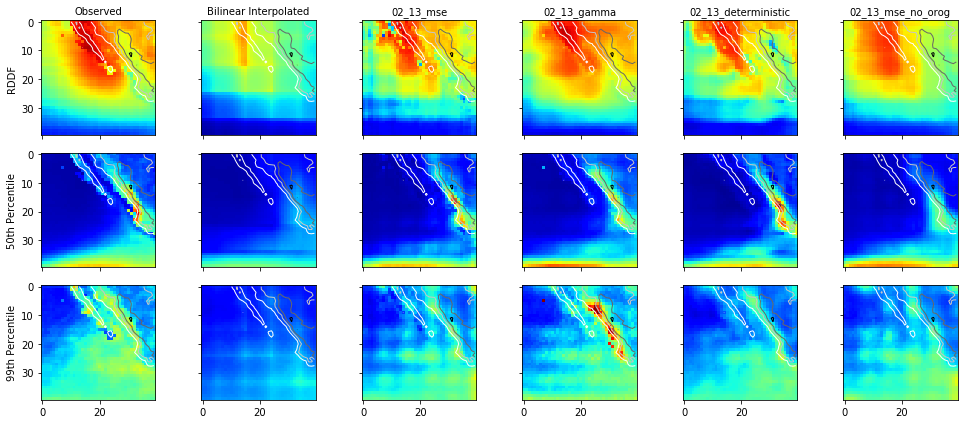

In [24]:
paths = [os.path.join(model, '{}_{}'.format(phase, load_epoch)) for model in models]
plot_percentiles(paths, area, percentiles, vlims=[[0, 8], [0,80]])

## 4b) plot percentiles for mean_gamma

for percentile 50 observed min=0.2605477273464203, observed_max=7.335109710693359
for percentile 99 observed min=9.784448165893563, observed_max=56.52648437499981
for percentile 50 in path results/02_13_gamma/test_14, min=0.22600776702165604, max=6.622820854187012
for percentile 99 in path results/02_13_gamma/test_14, min=8.611889600753784, max=50.974002571105984


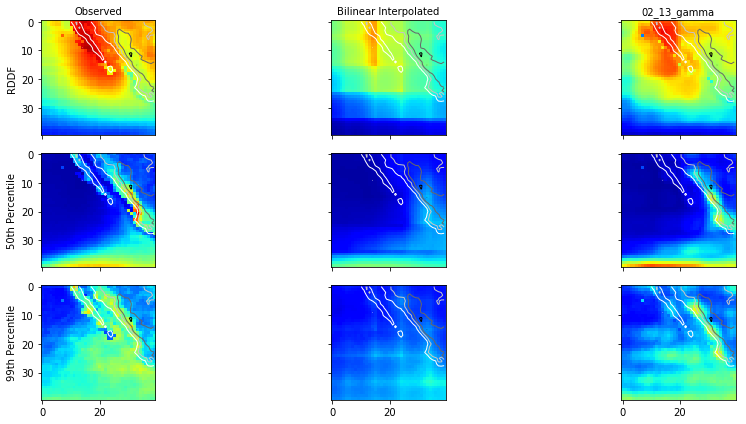

In [25]:
paths = [os.path.join('results/02_13_gamma/', '{}_{}'.format(phase, load_epoch))]
plot_percentiles(paths, area, percentiles,mean_downscaled=True, vlims=[[0, 8], [0,80]])
# todo scale

## 5. Plot mean value for Columbia

orog min=-58.06544876098633, max=4132.0
pr min=0.04760937765240669, max=20.46773910522461
standard pr min0.07089309394359589, max16.708778381347656


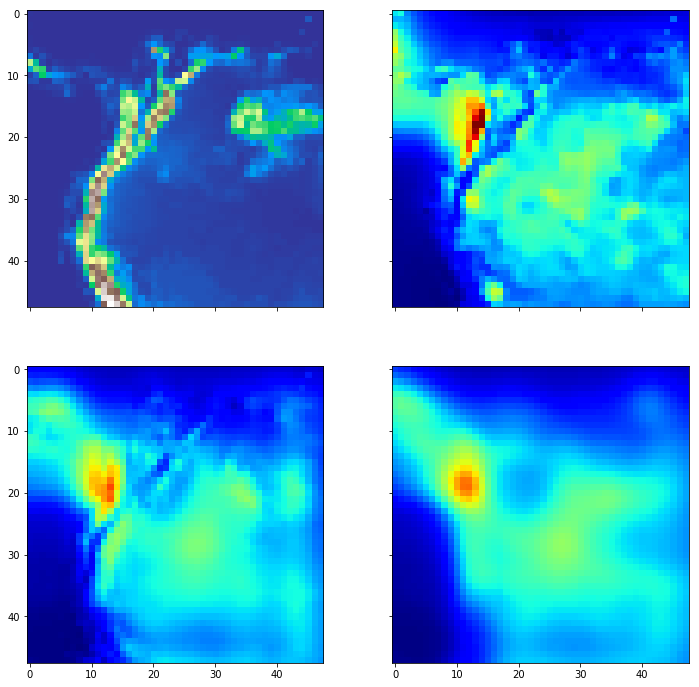

In [26]:
with Dataset('results/02_13_mse/test_14/t.val.lat48_lon560.nc4', "r", format="NETCDF4") as file:
    pr = normalized_flux_to_mm_per_d(file['pr'][:], std)
    standard_pr_recon = normalized_flux_to_mm_per_d(file['downscaled_pr_0'][:],std)
    orog = file['orog'][:]*std_orog
with Dataset('results/02_13_mse_no_orog/test_14/t.val.lat48_lon560.nc4', "r", format="NETCDF4") as file:
    no_orog_pr_recon = normalized_flux_to_mm_per_d(file['downscaled_pr_0'][:],std)
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize = (12, 12))
axes[0,0].imshow(orog,cmap=plt.get_cmap('terrain'),vmin=0, vmax=4000)
axes[0,1].imshow(pr[0,:,:],cmap=plt.get_cmap('jet'),vmin=0, vmax=20)
axes[1,0].imshow(standard_pr_recon[0,:,:],cmap=plt.get_cmap('jet'),vmin=0, vmax=20)
axes[1,1].imshow(no_orog_pr_recon[0,:,:],cmap=plt.get_cmap('jet'),vmin=0, vmax=20)

print ('orog min={}, max={}'.format(orog.min(), orog.max()))
print ('pr min={}, max={}'.format(pr.min(), pr.max()))
print('standard pr min{}, max{}'.format(standard_pr_recon.min(),standard_pr_recon.max()))


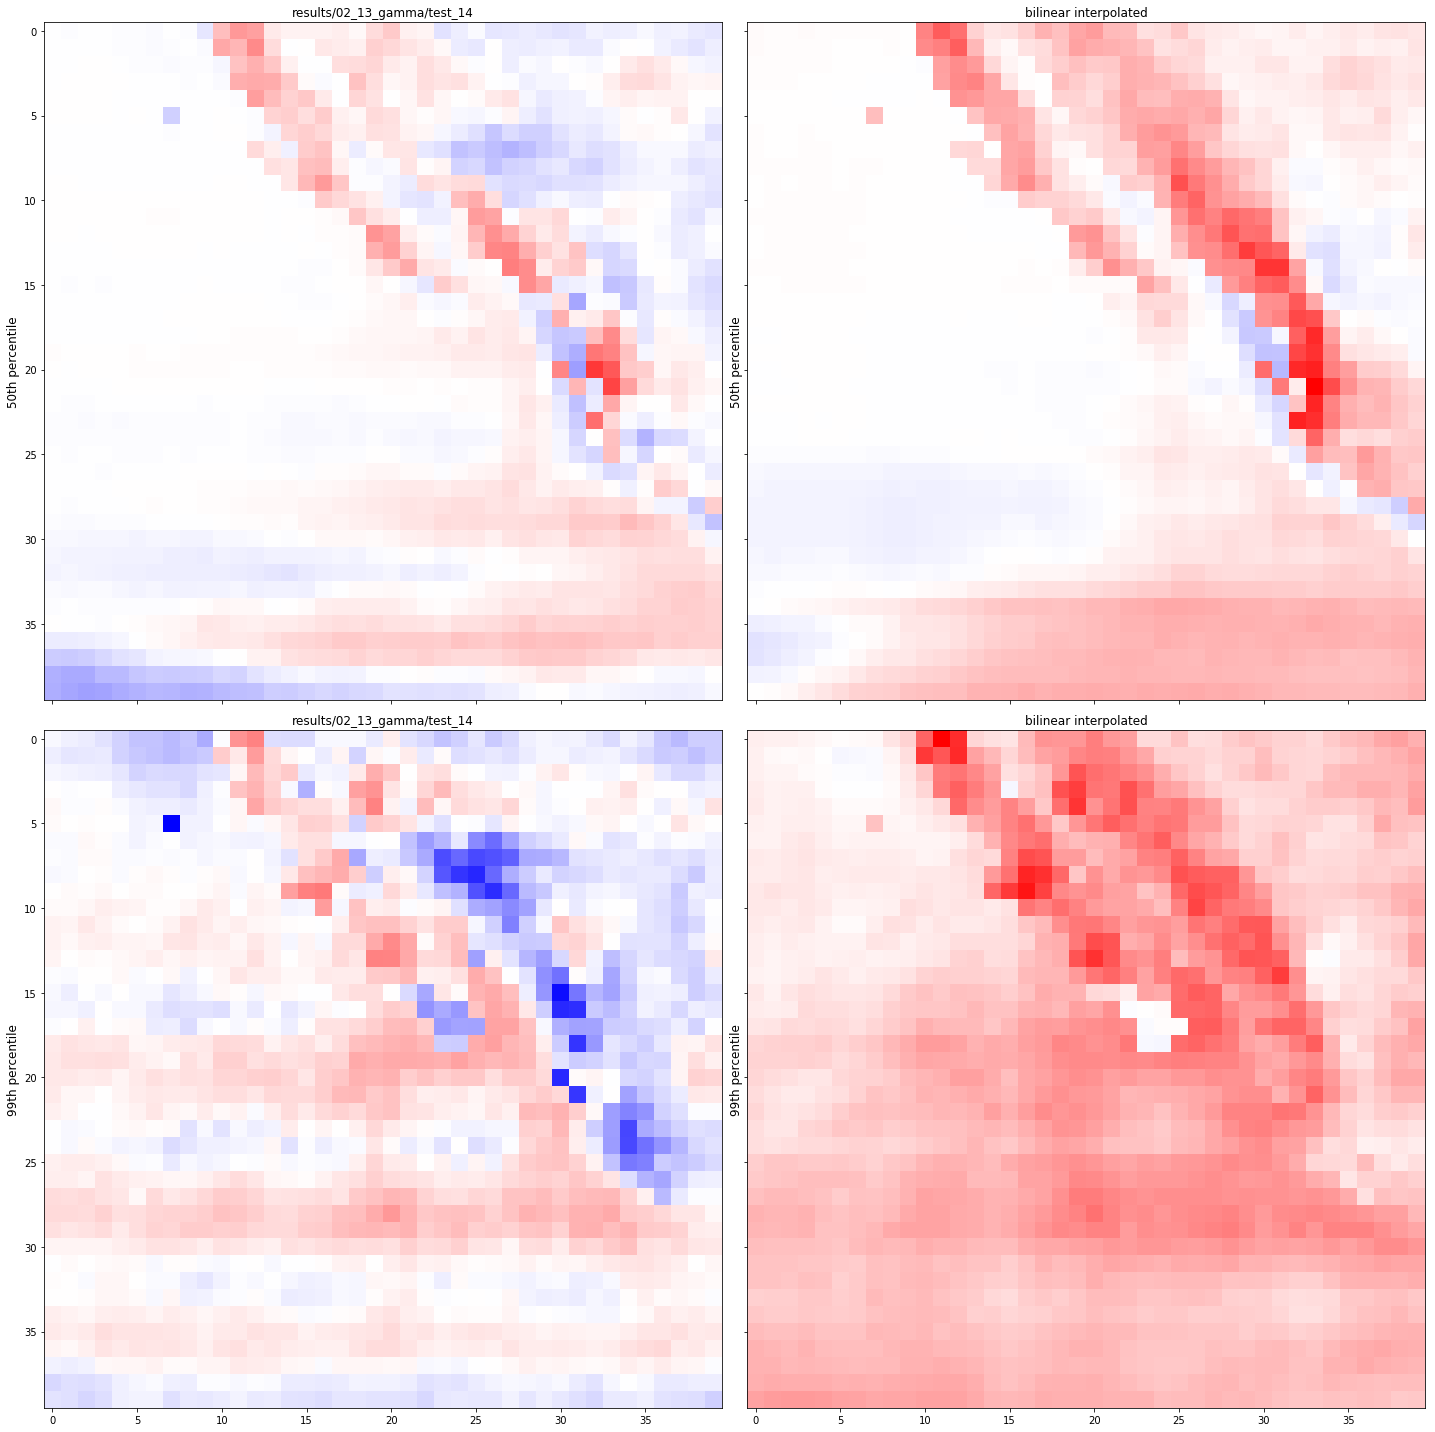

In [27]:
plot_percentile_errors(paths, area, percentiles)

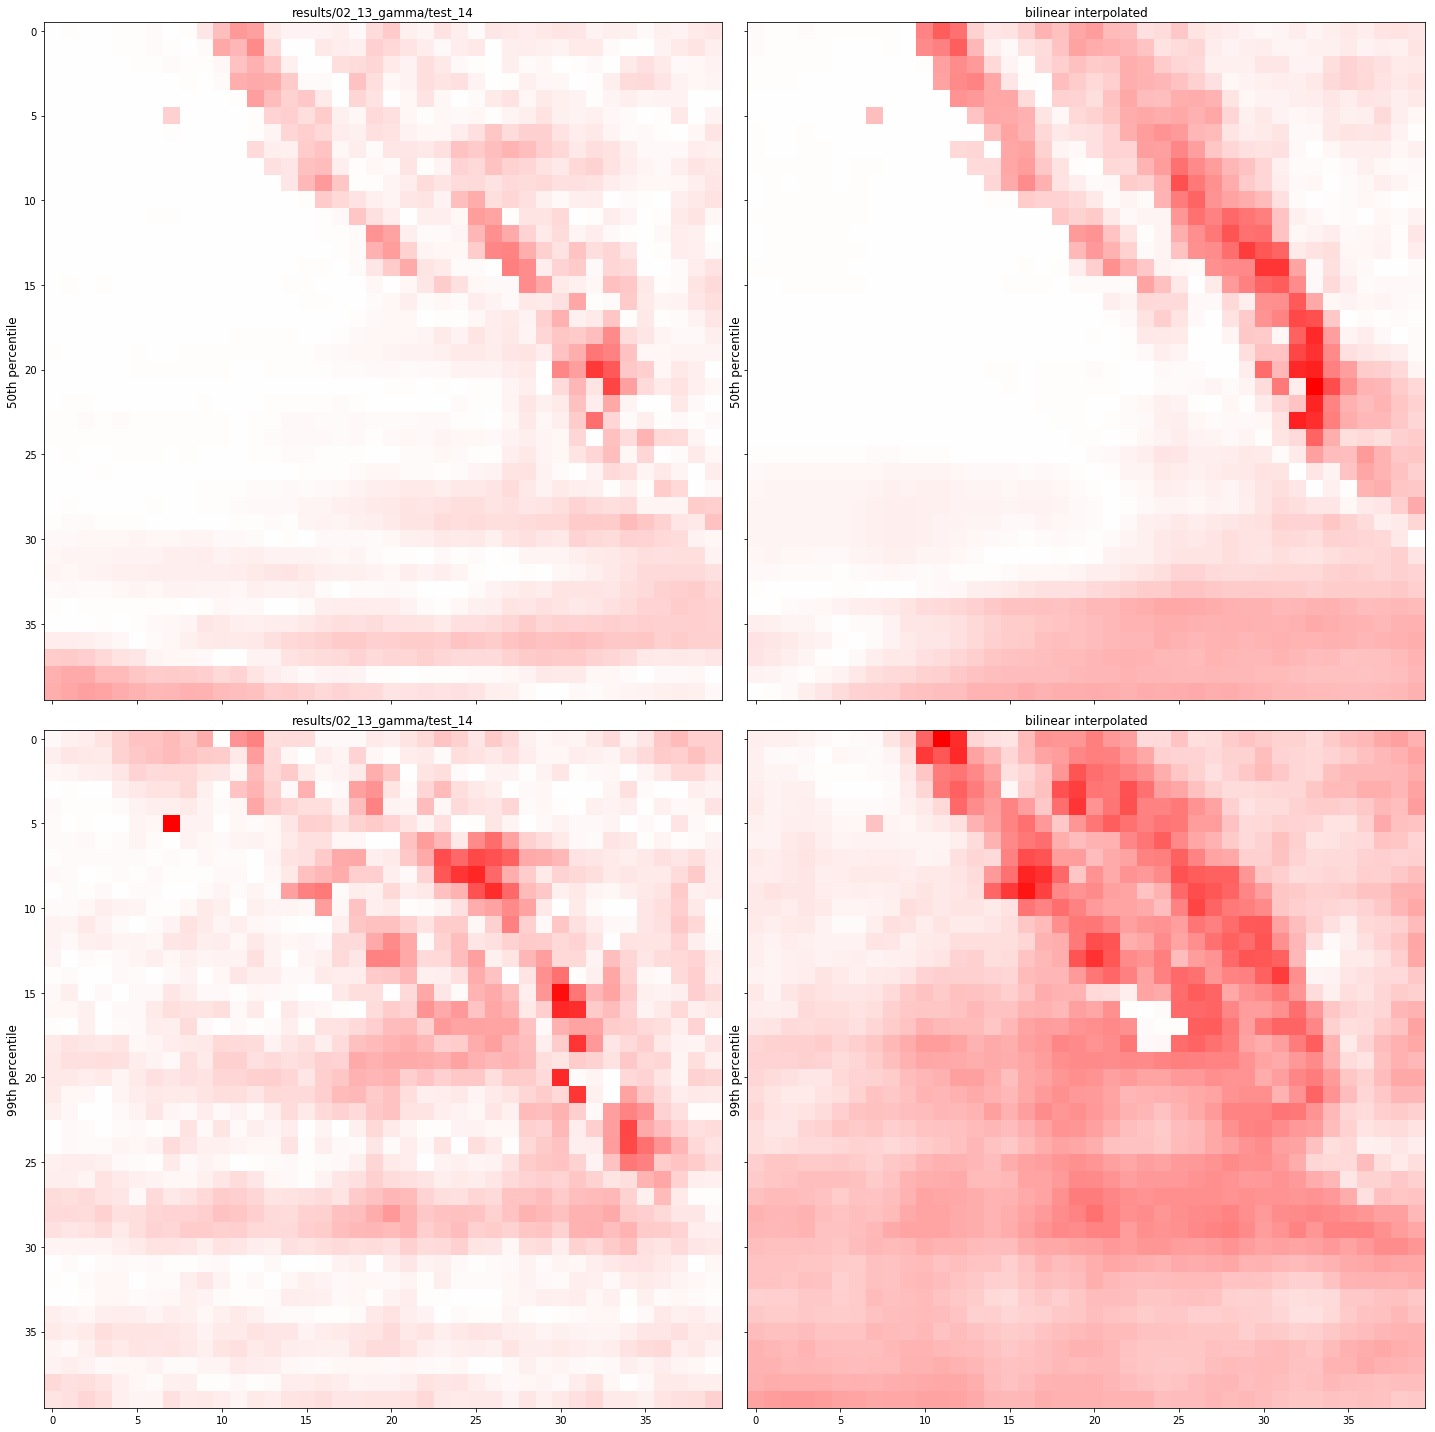

In [28]:
plot_percentile_errors(paths, area, percentiles, absolute=True)

In [29]:
area = 'val.lat48_lon560.nc4'

for percentile 50 observed min=0.16128592193126678, observed_max=13.24787950515747
for percentile 99 observed min=4.996091670989983, observed_max=179.0007148742675
for percentile 50 in path results/02_13_mse/test_14, min=0.18175409734249115, max=12.168503761291504
for percentile 99 in path results/02_13_mse/test_14, min=4.079001545906083, max=90.79847137451193
for percentile 50 in path results/02_13_gamma/test_14, min=0.19265829026699066, max=10.070799827575684
for percentile 99 in path results/02_13_gamma/test_14, min=5.3793524360656875, max=155.77806701660174
for percentile 50 in path results/02_13_deterministic/test_14, min=0.16004446893930435, max=13.3474702835083
for percentile 99 in path results/02_13_deterministic/test_14, min=3.0856867432594206, max=122.50909835815426
for percentile 50 in path results/02_13_mse_no_orog/test_14, min=0.1581980437040329, max=10.244526386260986
for percentile 99 in path results/02_13_mse_no_orog/test_14, min=4.618996620178233, max=96.27598739624024

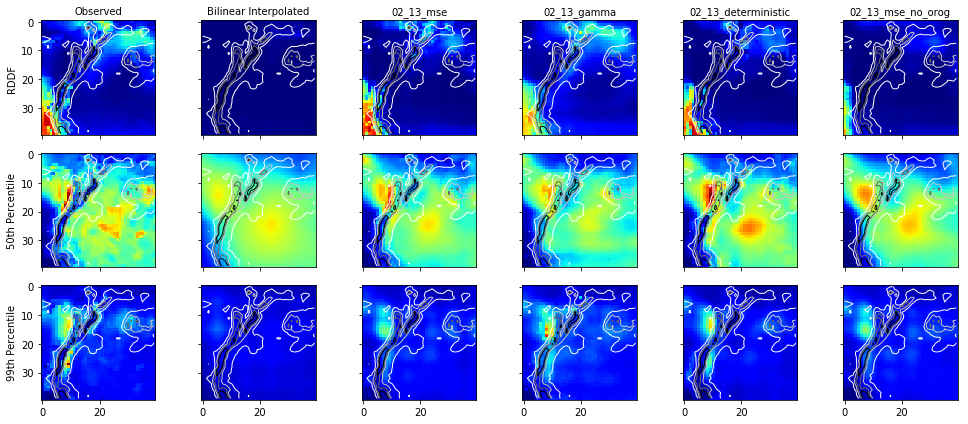

In [30]:
paths = [os.path.join(model, '{}_{}'.format(phase, load_epoch)) for model in models]
plot_percentiles(paths, area, percentiles)

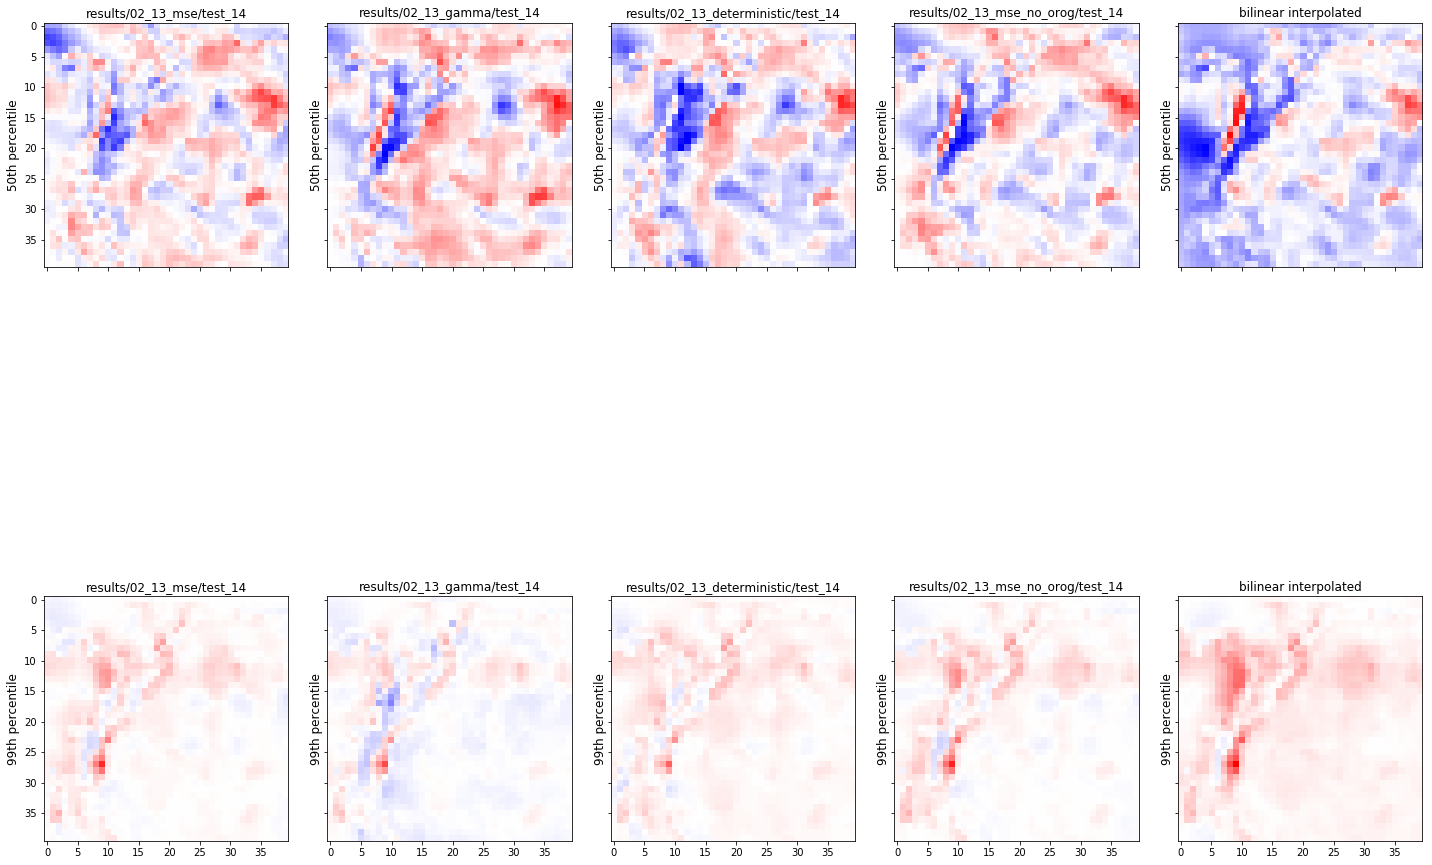

In [32]:
plot_percentile_errors(paths, area, percentiles)

## Dry day fraction

In [33]:
def plot_dry_d_error(paths, area):
    fig, axes = plt.subplots(2, len(paths)+1, sharex=True, sharey=True, figsize = (20, 20))
    # plot pr and interpol_pr, set v_min, v_max to the pr max and min value
    pr, _, pr_interpol, t = read_data(path=os.path.join(paths[0], area))
    dry_d_frac = np.sum(pr <= 0.1,axis=0)/t
    interpol_dry_d_frac = np.sum(pr_interpol <= 0.1, axis=0)/t
    error_interpol_dry_d_frac = interpol_dry_d_frac - dry_d_frac
    vmax=max([error_interpol_dry_d_frac.min(), error_interpol_dry_d_frac.max()])
    # plot error
    axes[0,-1].imshow(error_interpol_dry_d_frac, cmap=plt.get_cmap('bwr'),
                     vmin=-1, vmax=1)
    axes[0,-1].set_title('bilinear interpolated')
    axes[0,-1].set_ylabel('error', rotation=90, size='large')
    # plot abs error
    axes[1,-1].imshow(np.abs(error_interpol_dry_d_frac), cmap=plt.get_cmap('bwr'),
                     vmin=-1, vmax=1)
    axes[1,-1].set_title('bilinear interpolated')
    axes[1,-1].set_ylabel('abs error', rotation=90, size='large')
    for j in range(len(paths)):
        # compute dry day frequences
        _, pr_recon, _,  _= read_data(path=os.path.join(paths[j], area))
        recon_dry_d_frac = np.sum(pr_recon <= 0.1, axis=0)/t
        error_recon_dry_d_frac = recon_dry_d_frac - dry_d_frac
        # plot
        axes[0,j].imshow(error_recon_dry_d_frac, cmap=plt.get_cmap('bwr'),
                         vmin=-1, vmax=1)
        axes[0,j].set_title(paths[j])
        axes[0,j].set_ylabel('error', rotation=90, size='large')
        # plot abs error
        axes[1,j].imshow(np.abs(error_recon_dry_d_frac), cmap=plt.get_cmap('bwr'),
                         vmin=-1, vmax=1)
        axes[1,j].set_title(paths[j])
        axes[1,j].set_ylabel('abs error', rotation=90, size='large')        
    fig.tight_layout()
    plt.show()

In [34]:
def plot_dry_d(paths, area):
    fig, axes = plt.subplots(1, len(paths)+2, sharex=True, sharey=True, figsize = (20, 20))
    # plot pr and interpol_pr, set v_min, v_max to the pr max and min value
    pr, _, pr_interpol, t = read_data(path=os.path.join(paths[0], area))
    dry_d_frac = np.sum(pr <= 0.1,axis=0)/t
    interpol_dry_d_frac = np.sum(pr_interpol <= 0.1, axis=0)/t
    # plot
    axes[-2].imshow(interpol_dry_d_frac, cmap=plt.get_cmap('bwr'),
                     vmin=-1, vmax=1)
    axes[-2].set_title('bilinear interpolated')
    axes[-1].imshow(dry_d_frac, cmap=plt.get_cmap('bwr'),
                     vmin=-1, vmax=1)
    axes[-1].set_title('observed')
    for j in range(len(paths)):
        # compute dry day frequences
        _, pr_recon, _,  _= read_data(path=os.path.join(paths[j], area))
        recon_dry_d_frac = np.sum(pr_recon <= 0.1, axis=0)/t
        # plot
        axes[j].imshow(recon_dry_d_frac, cmap=plt.get_cmap('bwr'),
                         vmin=-1, vmax=1)
        axes[j].set_title(paths[j])
        axes[j].set_ylabel('dry day frequency error', rotation=90, size='large')
    fig.tight_layout()
    plt.show()

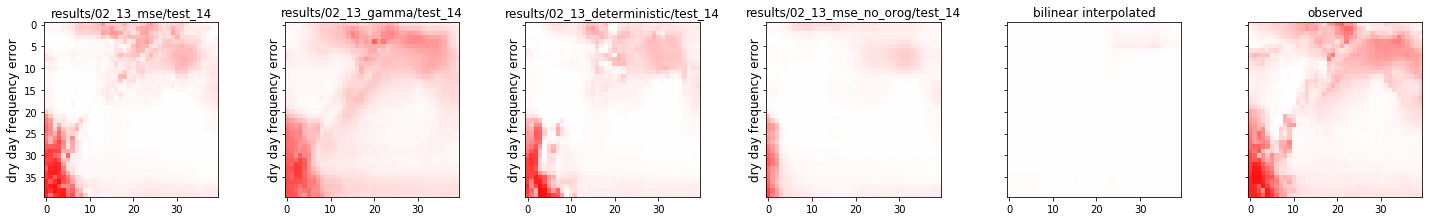

In [35]:
plot_dry_d(paths=paths, area=area)

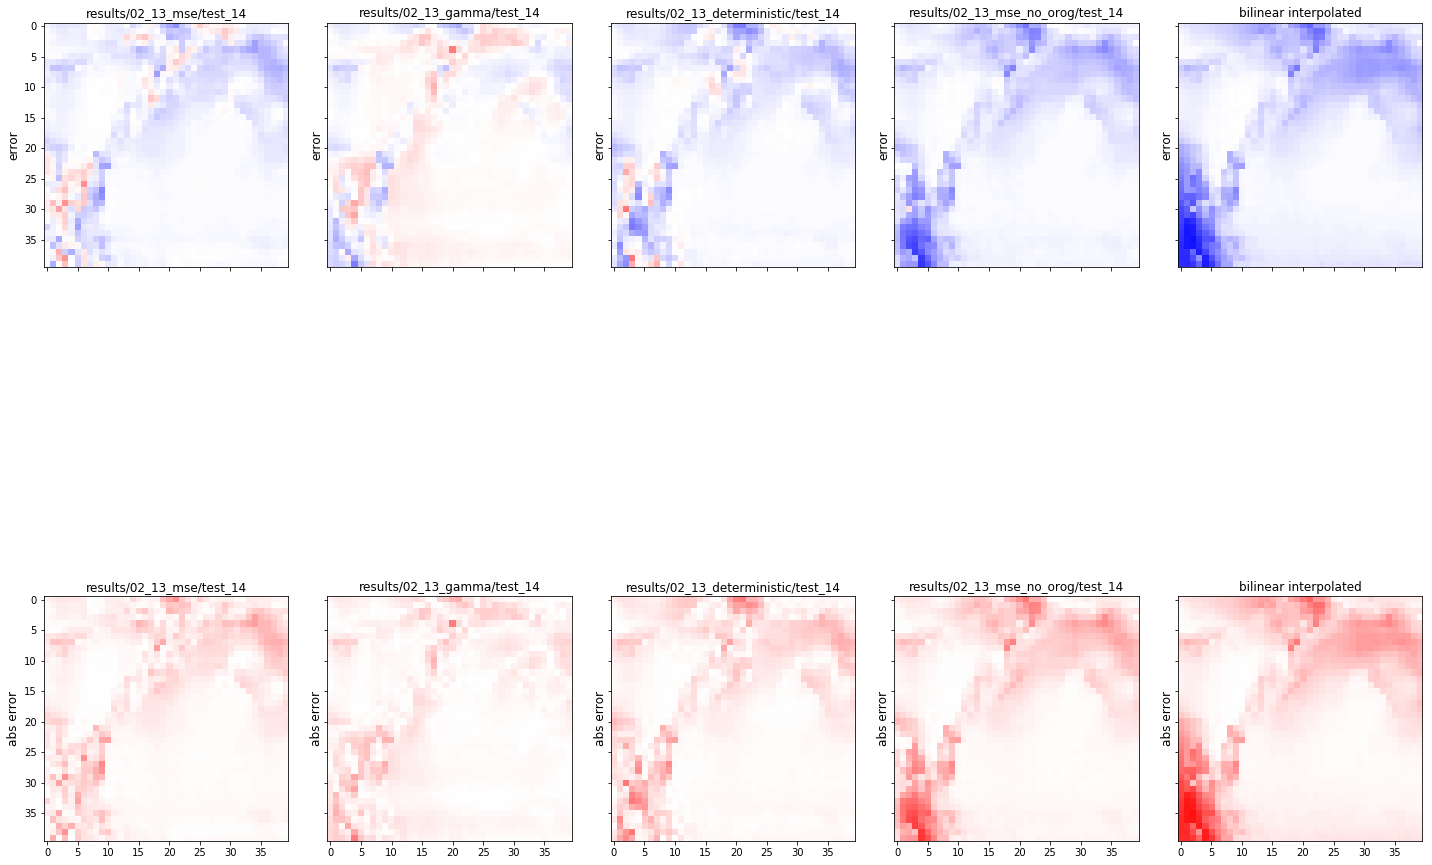

In [36]:
plot_dry_d_error(paths=paths, area=area)